# Random Forrest Model Assessment

In [49]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, r2_score, recall_score, precision_score, f1_score, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV

## Import training data

In [2]:
X_train = pd.read_csv('../data/X_train_trans.csv')

pickle_in = open('../data/y_train.pickle', 'rb')
y_train = pickle.load(pickle_in)

## Confusion Matrix Function

In [3]:
#creating a confusion matrix template
import warnings
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [10, 5]

# from https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Random Forrest Classification

In [4]:
clf = RandomForestClassifier(n_jobs=-1)
clf.fit(X_train, y_train);

In [5]:
clf.decision_path(X_train);

In [6]:
clf.feature_importances_

array([0.02668664, 0.02088063, 0.03804555, 0.06689206, 0.02366561,
       0.07467222, 0.03386975, 0.01959382, 0.02942966, 0.02322511,
       0.02204138, 0.0244306 , 0.03264806, 0.0359581 , 0.03390859,
       0.11758938, 0.06226721, 0.02089922, 0.18490953, 0.00283028,
       0.00287127, 0.07512803, 0.02755729])

In [7]:
# y_pred = clf.predict(X_train)

# cm = confusion_matrix(y_train, y_pred)
# classes = ['Maintain', 'Churn']
# plot_confusion_matrix(cm, classes,
#                       normalize=False,
#                       title='Confusion matrix')

# #Checking performance our model with classification report.
# print(classification_report(y_train, y_pred))
# #Checking performance our model with ROC Score.
# print ('roc_auc_score:', roc_auc_score(y_train, y_pred))

In [8]:
# print('Precision: {}\nAccuracy: {}\nRecall: {}\nF1: {}'.format(precision_score(y_train, y_pred), 
#                 accuracy_score(y_train, y_pred), 
#                 recall_score(y_train, y_pred), 
#                 f1_score(y_train, y_pred)))

In [88]:
cvs = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'precision')
print('Average CV score: {}'.format(np.average(cvs)))

Average CV score: 0.8310185185185185


In [89]:
X_train.shape[0]/5

466.6

In [90]:
max_features = len(X_train.columns)

In [91]:
np.sqrt(max_features), np.log2(max_features)

(4.795831523312719, 4.523561956057013)

In [103]:
params = {'n_estimators': [50, 100, 250, 500],
          'max_depth': [3, 4, 7, 10],
          'min_samples_leaf': [50, 100, 250, 500],
          'max_features': ['sqrt', 'log2', 'auto']
}

In [104]:
gscv = GridSearchCV(clf, params, n_jobs = -1, verbose = 1)
gscv.fit(X_train, y_train)

sorted(gscv.cv_results_.keys())



### Example data
# from sklearn import svm, datasets

# iris = datasets.load_iris()
# parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
# svc = svm.SVC()
# clf = GridSearchCV(svc, parameters)
# clf.fit(iris.data, iris.target)


# sorted(clf.cv_results_.keys())

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:  1.1min finished


['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_max_depth',
 'param_max_features',
 'param_min_samples_leaf',
 'param_n_estimators',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [105]:
gscv.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_max_features', 'param_min_samples_leaf', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [106]:
results = pd.DataFrame(gscv.cv_results_)
results[['rank_test_score', 'mean_test_score', 'param_max_depth',
         'param_max_features', 'param_min_samples_leaf', 'param_n_estimators']].\
            sort_values(by='rank_test_score').head(5)

,rank_test_score,mean_test_score,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators
178,1,0.892844,10,auto,50,250
160,2,0.891128,10,log2,50,50
130,3,0.890268,7,auto,50,250
161,4,0.889413,10,log2,50,100
48,5,0.889412,4,sqrt,50,50


In [107]:
gscv.best_index_

178

In [108]:
gscv.cv_results_['params'][gscv.best_index_]

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 50,
 'n_estimators': 250}

In [109]:
gscv.cv_results_['mean_test_score'][gscv.best_index_]

0.8928435544200495

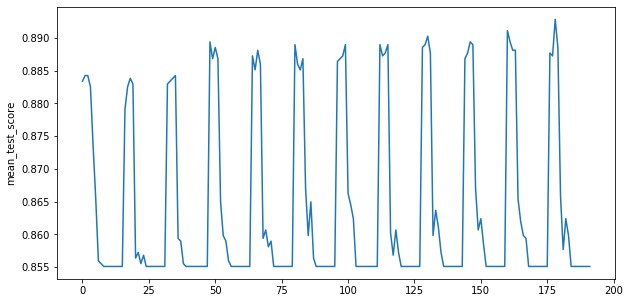

In [110]:
sns.lineplot(x = results.index, y = results.mean_test_score)

In [111]:
results.index

RangeIndex(start=0, stop=192, step=1)

## Best Parameters...
- max_depth = 10
- max_features = 'auto'
- min_samples_leaf = 50
- n_estimators = 250

In [116]:
best = RandomForestClassifier(max_depth=7, max_features=7, min_samples_leaf=50, n_estimators=500, n_jobs=-1)
best.fit(X_train, y_train);

In [117]:
feats = list(zip(X_train.columns, clf.feature_importances_))

In [120]:
pd.DataFrame(feats, columns = ['feature', 'importance']).\
                                sort_values(by = 'importance', ascending = False).head(10)

,feature,importance
18,total_charge,0.184910
15,customer_service_calls,0.117589
21,x1_yes,0.075128
5,total_day_charge,0.074672
3,total_day_minutes,0.066892
16,total_minutes,0.062267
2,number_vmail_messages,0.038046
13,total_intl_calls,0.035958
14,total_intl_charge,0.033909
6,total_eve_minutes,0.033870


Most important features include:
- Total charge
- customer_service_calls
- x1_yes (international plan yes/no)
- total_day_charge
- total_day_minutes